# Network Motif Analysis for Directed Graphs
# Identification and Z-score calculation for 3-node subgraphs

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict, Counter
import pandas as pd
from tqdm.notebook import tqdm
import os
import urllib.request
import time

# Set random seed for reproducibility
np.random.seed(42)

## 1. Loading a Real-World Directed Network

In [2]:
def load_arxiv_network():
    """
    Load the arXiv HEP-TH citation network.
    Returns a directed graph.
    """
    # File name
    edges_file = "cit-HepTh.txt\Cit-HepTh.txt"
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add edges from the citation file
    with open(edges_file, 'r') as f:
        for line in f:
            # Skip comment lines starting with #
            if line.startswith('#'):
                continue
            # Parse the line
            parts = line.strip().split()
            if len(parts) == 2:
                source, target = parts
                G.add_edge(source, target)
    
    print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

# Load the network
G_original = load_arxiv_network()

def get_subgraph(G, min_size=1000, max_size=4000):
    """
    Extract a connected subgraph with size between min_size and max_size nodes.
    If no component is within the size range, returns a subgraph of the largest component.
    """
    if not nx.is_directed(G):
        components = list(nx.connected_components(G))
    else:
        # For directed graphs, we convert to undirected for finding components
        G_undirected = G.to_undirected()
        components = list(nx.connected_components(G_undirected))
    
    # Sort components by size (largest first)
    components.sort(key=len, reverse=True)
    
    # Take the largest component that has at least min_size nodes
    for component in components:
        if min_size <= len(component) <= max_size:
            subgraph = G.subgraph(component).copy()
            return subgraph
    
    # If no component is in the desired range, take a subset of the largest component
    largest_component = list(components[0])
    if len(largest_component) > max_size:
        # Randomly select max_size nodes from the largest component
        selected_nodes = np.random.choice(largest_component, size=max_size, replace=False)
        subgraph = G.subgraph(selected_nodes).copy()
        
        # Ensure the subgraph is connected (if directed, check if weakly connected)
        if nx.is_directed(G):
            if not nx.is_weakly_connected(subgraph):
                # If not connected, find the largest connected component
                subgraph_undirected = subgraph.to_undirected()
                largest_cc = max(nx.connected_components(subgraph_undirected), key=len)
                subgraph = G.subgraph(largest_cc).copy()
        else:
            if not nx.is_connected(subgraph):
                largest_cc = max(nx.connected_components(subgraph), key=len)
                subgraph = G.subgraph(largest_cc).copy()
        
        return subgraph
    else:
        # Return the largest component if it's smaller than max_size
        return G.subgraph(largest_component).copy()

# Extract a subgraph of reasonable size
G = get_subgraph(G_original, min_size=500, max_size=5000)
print(f"Working with a subgraph of {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

<>:7: SyntaxWarning: invalid escape sequence '\C'
<>:7: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Rahul\AppData\Local\Temp\ipykernel_17336\1274452657.py:7: SyntaxWarning: invalid escape sequence '\C'
  edges_file = "cit-HepTh.txt\Cit-HepTh.txt"


Loaded graph with 27770 nodes and 352807 edges
Working with a subgraph of 3703 nodes and 11522 edges


## 2. Strategy to Generate All Unique 3-Node Connected Subgraphs

Generated 13 unique 3-node connected directed subgraphs


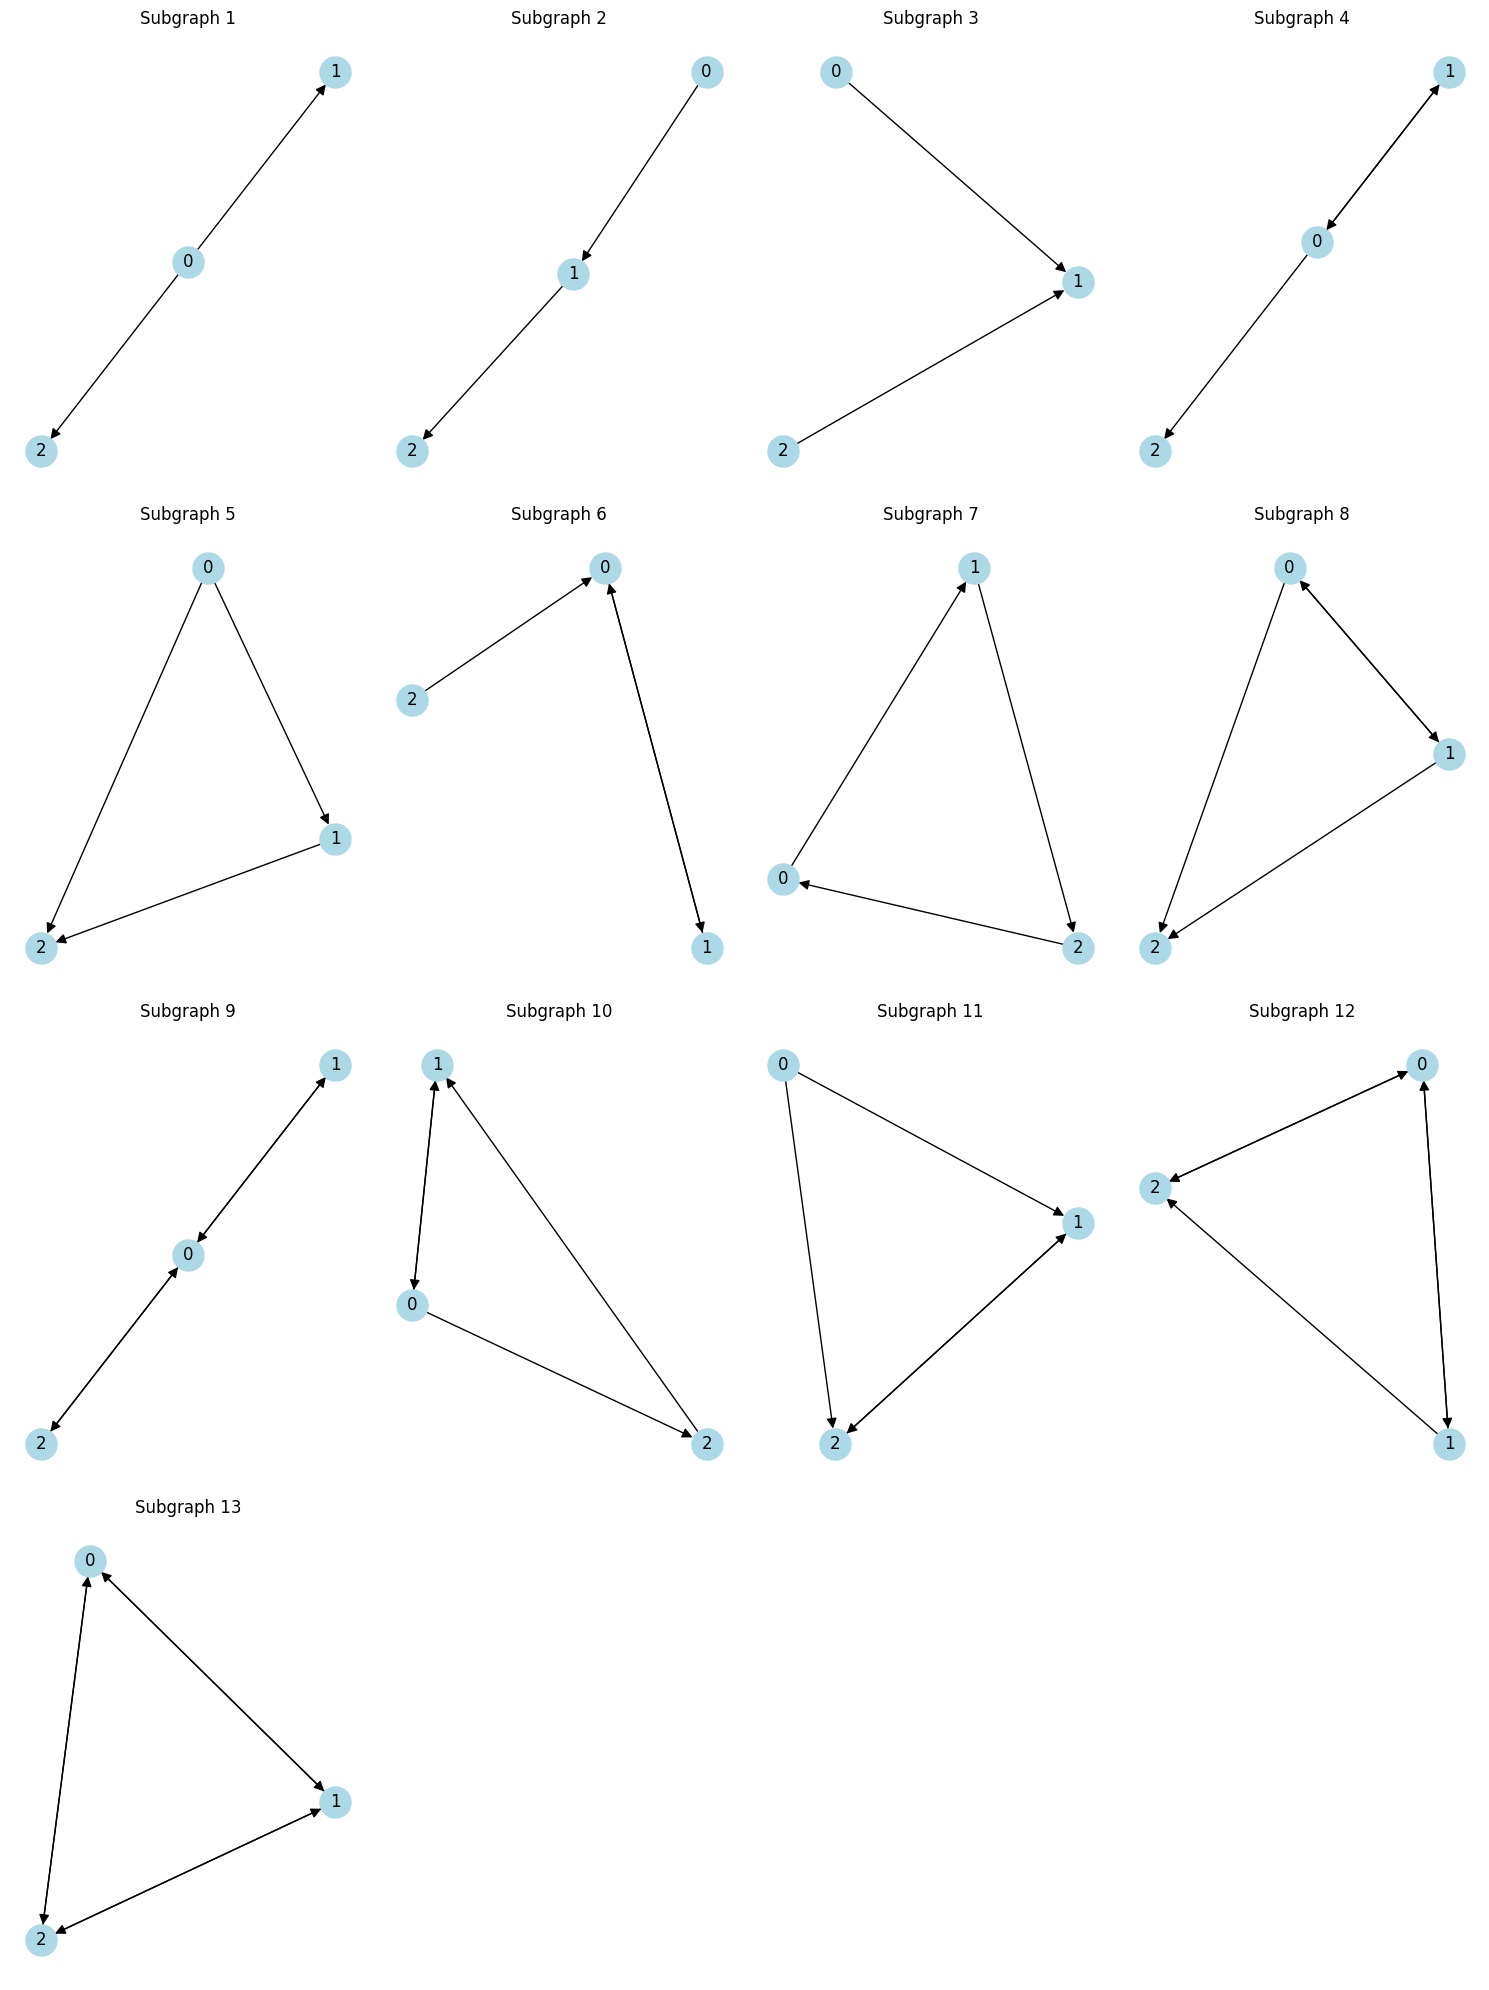

In [ ]:
from networkx.algorithms import isomorphism

def generate_all_possible_3node_digraphs():
    """
    Generate all possible unique 3-node connected directed subgraphs.
    
    Returns:
    --------
    list of nx.DiGraph
        List of all unique 3-node connected directed graphs
    dict
        Mapping from graph ID to its adjacency matrix representation
    """
    # For 3 nodes, there are potentially 2^(3*3 - 3) = 2^6 = 64 different directed graphs
    # (excluding self-loops)
    # But we only want connected graphs, so we'll generate and filter
    
    nodes = [0, 1, 2]
    all_possible_edges = [(i, j) for i in nodes for j in nodes if i != j]
    
    # Dictionary to store unique graphs by their canonical adjacency matrix
    unique_graphs = {}
    
    # Generate all possible combinations of edges
    for num_edges in range(1, len(all_possible_edges) + 1):
        for edges in itertools.combinations(all_possible_edges, num_edges):
            # Create a directed graph with these edges
            G = nx.DiGraph()
            G.add_nodes_from(nodes)
            G.add_edges_from(edges)
            
            # Check if the graph is weakly connected
            if nx.is_weakly_connected(G):
                # Create adjacency matrix as a canonical representation
                adj_matrix = nx.to_numpy_array(G)
                
                # Convert to tuple for hashability (used as dictionary key)
                adj_tuple = tuple(map(tuple, adj_matrix))
                
                # Check for isomorphism with existing graphs
                is_isomorphic = False
                for existing_adj in unique_graphs:
                    if is_isomorphic_adj_matrices(adj_tuple, existing_adj, nodes):
                        is_isomorphic = True
                        break
                
                if not is_isomorphic:
                    unique_graphs[adj_tuple] = G
    
    # Assign IDs to the unique graphs
    graph_ids = {}
    for i, (adj_matrix, G) in enumerate(unique_graphs.items()):
        graph_ids[i] = adj_matrix
    
    print(f"Generated {len(unique_graphs)} unique 3-node connected directed subgraphs")
    return list(unique_graphs.values()), graph_ids

def is_isomorphic_adj_matrices(adj1, adj2, nodes):
    """
    Check if two adjacency matrices represent isomorphic directed graphs.
    """
    adj1_np = np.array(adj1)
    adj2_np = np.array(adj2)
    
    G1 = nx.from_numpy_array(adj1_np, create_using=nx.DiGraph)
    G2 = nx.from_numpy_array(adj2_np, create_using=nx.DiGraph)
    
    gm = isomorphism.DiGraphMatcher(G1, G2)
    return gm.is_isomorphic()

def visualize_subgraphs(subgraphs, ncols=4, figsize=(15, 20)):
    """
    Visualize the subgraphs in a grid.
    
    Parameters:
    -----------
    subgraphs : list of nx.DiGraph
        List of subgraphs to visualize
    ncols : int
        Number of columns in the grid
    figsize : tuple
        Figure size
    """
    nrows = int(np.ceil(len(subgraphs) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, G in enumerate(subgraphs):
        if i < len(axes):
            ax = axes[i]
            ax.set_title(f"Subgraph {i+1}")
            pos = nx.spring_layout(G, seed=42)  # Position nodes using spring layout
            nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', 
                    node_size=500, arrowsize=15, arrows=True)
        else:
            print(f"Warning: Not enough axes for all subgraphs")
            break
    
    # Hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("unique_3node_subgraphs.png", dpi=300)
    plt.show()

# Generate all unique 3-node connected directed subgraphs
unique_subgraphs, graph_ids = generate_all_possible_3node_digraphs()

# Visualize the unique subgraphs
visualize_subgraphs(unique_subgraphs, ncols=4, figsize=(15, 20))

## 3. Identifying Subgraph Patterns in the Real Network

In [ ]:
from networkx.algorithms import isomorphism
def get_node_triads(G):
    """
    Return a generator over all 3-node combinations in the graph (no large list).
    
    Parameters:
    -----------
    G : nx.DiGraph
        The graph to analyze
    
    Returns:
    --------
    iterator
        An iterator that yields 3-node tuples
    """
    return itertools.combinations(G.nodes(), 3)

def get_subgraph_pattern(G, nodes):
    """
    Get the subgraph pattern for a set of nodes.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The graph to analyze
    nodes : list or tuple
        List of nodes to extract the subgraph
    
    Returns:
    --------
    nx.DiGraph
        The subgraph induced by the nodes
    """
    return G.subgraph(nodes).copy()

def assign_pattern_id(pattern, unique_subgraphs):
    """
    Assign an ID to a pattern based on directed isomorphism with unique subgraphs.
    """
    for i, unique_pattern in enumerate(unique_subgraphs):
        # Enforce directed isomorphism
        gm = isomorphism.DiGraphMatcher(pattern, unique_pattern)
        if gm.is_isomorphic():
            return i
    return -1

def count_subgraph_occurrences(G, unique_subgraphs, max_samples=None):
    """
    Count occurrences of each unique subgraph pattern in the graph, 
    using a streaming approach to avoid high memory usage.

    Parameters:
    -----------
    G : nx.DiGraph
        The graph to analyze
    unique_subgraphs : list of nx.DiGraph
        List of unique subgraph patterns
    max_samples : int, optional
        Maximum number of triads to analyze

    Returns:
    --------
    dict
        Mapping from pattern ID to count
    """
    # Create an iterator over all 3-node combinations (no huge list!)
    triad_iter = get_node_triads(G)
    
    pattern_counts = defaultdict(int)
    
    # If you want a nice progress bar, you can provide 'total' to tqdm:
    # total_triads = math.comb(len(G.nodes()), 3)  # Could be huge for large G
    # triad_iter = tqdm(triad_iter, desc="Analyzing triads", total=total_triads)
    #
    # If computing math.comb(len(G.nodes()), 3) is too large, you can omit 'total'
    # so tqdm won't show a "percent complete", but it will still show the iteration rate:
    
    triad_iter = tqdm(triad_iter, desc="Analyzing triads")
    
    n_processed = 0
    for triad in triad_iter:
        if max_samples is not None and n_processed >= max_samples:
            break
        
        # Get the subgraph for this triad
        subgraph = get_subgraph_pattern(G, triad)
        
        # Only consider connected subgraphs (weakly connected in a DiGraph)
        if nx.is_weakly_connected(subgraph):
            pattern_id = assign_pattern_id(subgraph, unique_subgraphs)
            if pattern_id >= 0:
                pattern_counts[pattern_id] += 1
        
        n_processed += 1
    
    return pattern_counts

# --------------------------------------------------------------------
# Example usage:
# --------------------------------------------------------------------
# Suppose you already have:
#   1) A directed graph 'G'
#   2) A list of unique subgraphs 'unique_subgraphs' (3-node motifs)
#
# Then you can do:
# --------------------------------------------------------------------
# real_counts = count_subgraph_occurrences(G, unique_subgraphs, max_samples=10000)
# print(f"Found {sum(real_counts.values())} connected 3-node subgraphs in the real network")
# print(f"Distributed across {len(real_counts)} unique patterns")
# --------------------------------------------------------------------

## 4. Generating Random Networks and Computing Z-Scores

In [5]:
def generate_random_network(G, model='configuration', num_swaps=10):
    """
    Generate a random network that preserves the degree sequence of the original network.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The original graph
    model : str
        The randomization model to use ('configuration' or 'edge_swap')
    num_swaps : int
        Number of edge swaps per edge (for 'edge_swap' model)
    
    Returns:
    --------
    nx.DiGraph
        The randomized graph
    """
    if model == 'configuration':
        # Get in and out degree sequences
        in_degrees = [d for n, d in G.in_degree()]
        out_degrees = [d for n, d in G.out_degree()]
        
        # Generate random graph with the same degree sequence
        G_random = nx.directed_configuration_model(
            in_degrees, 
            out_degrees, 
            seed=np.random.randint(0, 10000)
        )
        
        # Remove parallel edges and self-loops
        G_random = nx.DiGraph(G_random)
        
    elif model == 'edge_swap':
        # Create a copy of the original graph
        G_random = G.copy()
        
        # Perform edge swaps
        edges = list(G_random.edges())
        n_swaps = int(num_swaps * len(edges))
        
        swapped = 0
        attempts = 0
        max_attempts = n_swaps * 10  # Limit attempts to avoid infinite loops
        
        while swapped < n_swaps and attempts < max_attempts:
            # Randomly select two edges
            idx1, idx2 = np.random.choice(len(edges), 2, replace=False)
            edge1 = edges[idx1]
            edge2 = edges[idx2]
            
            # Extract the source and target nodes
            u1, v1 = edge1
            u2, v2 = edge2
            
            # Check if the new edges already exist or would create self-loops
            if (u1 != v2 and u2 != v1 
                and not G_random.has_edge(u1, v2) 
                and not G_random.has_edge(u2, v1)):
                
                # Remove the original edges
                G_random.remove_edge(u1, v1)
                G_random.remove_edge(u2, v2)
                
                # Add the new edges
                G_random.add_edge(u1, v2)
                G_random.add_edge(u2, v1)
                
                # Update the edges list
                edges[idx1] = (u1, v2)
                edges[idx2] = (u2, v1)
                
                swapped += 1
                
            attempts += 1
    
    else:
        raise ValueError(f"Unknown randomization model: {model}")
    
    return G_random


def compute_z_scores(G, unique_subgraphs, num_random=100, random_model='configuration', max_samples=10000):
    """
    Compute Z-scores for each subgraph pattern.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The original graph
    unique_subgraphs : list of nx.DiGraph
        List of unique subgraph patterns
    num_random : int
        Number of random networks to generate
    random_model : str
        The randomization model to use
    max_samples : int
        Maximum number of triads to sample per graph
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with Z-scores and related statistics
    """
    # Count occurrences in the real network (uses count_subgraph_occurrences from Part 3)
    real_counts = count_subgraph_occurrences(G, unique_subgraphs, max_samples=max_samples)
    
    # Dictionary to store counts for each pattern in each random network
    random_counts = defaultdict(list)
    
    # Generate random networks and count patterns
    for i in tqdm(range(num_random), desc=f"Generating and analyzing {num_random} random networks"):
        # Generate a random network
        G_random = generate_random_network(G, model=random_model)
        
        # Count patterns in the random network
        counts = count_subgraph_occurrences(G_random, unique_subgraphs, max_samples=max_samples)
        
        # Store counts for each pattern
        for pattern_id in range(len(unique_subgraphs)):
            random_counts[pattern_id].append(counts.get(pattern_id, 0))
    
    # Compute statistics and Z-scores
    data = []
    for pattern_id in range(len(unique_subgraphs)):
        # Get counts for this pattern
        real_count = real_counts.get(pattern_id, 0)
        rand_counts = random_counts[pattern_id]
        
        # Compute statistics
        rand_mean = np.mean(rand_counts)
        rand_std = np.std(rand_counts)
        
        # Compute Z-score (avoid division by zero)
        z_score = 0 if rand_std == 0 else (real_count - rand_mean) / rand_std
        
        # Store data
        data.append({
            'Pattern ID': pattern_id,
            'Real Count': real_count,
            'Random Mean': rand_mean,
            'Random Std': rand_std,
            'Z-Score': z_score
        })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Sort by Z-score (absolute value, descending)
    df = df.sort_values(by='Z-Score', key=abs, ascending=False)
    
    return df


# --- Example call for Part 4 (assuming G and unique_subgraphs are defined) ---
z_scores_df = compute_z_scores(
    G,                 # G is defined in Part 1
    unique_subgraphs,  # from Part 2
    num_random=10, 
    random_model='edge_swap', 
    max_samples=5000
)
print(z_scores_df.head(10))


Analyzing triads: 0it [00:00, ?it/s]

Generating and analyzing 10 random networks:   0%|          | 0/10 [00:00<?, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

   Pattern ID  Real Count  Random Mean  Random Std  Z-Score
0           0           0          0.0         0.0        0
1           1           0          0.0         0.0        0
2           2           0          0.0         0.0        0
3           3           0          0.0         0.0        0
4           4           0          0.0         0.0        0
5           5           0          0.0         0.0        0
6           6           0          0.0         0.0        0
7           7           0          0.0         0.0        0
8           8           0          0.0         0.0        0
9           9           0          0.0         0.0        0


## 5. Identifying Motifs and Anti-Motifs

In [6]:
def identify_motifs(z_scores_df, threshold=2.0):
    """
    Identify motifs and anti-motifs based on Z-scores.
    
    Parameters:
    -----------
    z_scores_df : pandas.DataFrame
        DataFrame with Z-scores
    threshold : float
        Z-score threshold for significance
    
    Returns:
    --------
    tuple
        Lists of motif IDs and anti-motif IDs
    """
    motifs = z_scores_df[z_scores_df['Z-Score'] > threshold]['Pattern ID'].tolist()
    anti_motifs = z_scores_df[z_scores_df['Z-Score'] < -threshold]['Pattern ID'].tolist()
    
    return motifs, anti_motifs


def visualize_motifs(subgraphs, motifs, anti_motifs, figsize=(15, 10)):
    """
    Visualize motifs and anti-motifs.
    
    Parameters:
    -----------
    subgraphs : list of nx.DiGraph
        List of all unique subgraphs
    motifs : list
        List of motif pattern IDs
    anti_motifs : list
        List of anti-motif pattern IDs
    figsize : tuple
        Figure size
    """
    # Count motifs and anti-motifs
    n_motifs = len(motifs)
    n_anti_motifs = len(anti_motifs)
    
    # Determine layout
    if n_motifs > 0 and n_anti_motifs > 0:
        nrows = 2
        ncols = max(n_motifs, n_anti_motifs)
    elif n_motifs > 0:
        nrows = 1
        ncols = n_motifs
    elif n_anti_motifs > 0:
        nrows = 1
        ncols = n_anti_motifs
    else:
        print("No motifs or anti-motifs found")
        return
    
    # Create figure
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # Handle single row or column case
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1 or ncols == 1:
        axes = axes.reshape(nrows, ncols)
    
    # Plot motifs
    if n_motifs > 0:
        row = 0
        for col, pattern_id in enumerate(motifs):
            if col < ncols:
                ax = axes[row, col]
                ax.set_title(
                    f"Motif {pattern_id+1}\nZ-score: {z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]:.2f}"
                )
                pos = nx.spring_layout(subgraphs[pattern_id], seed=42)
                nx.draw(
                    subgraphs[pattern_id], pos, 
                    ax=ax, with_labels=True, 
                    node_color='green', node_size=500, 
                    arrowsize=15, arrows=True
                )
            else:
                print(f"Warning: Not enough columns for all motifs")
    
    # Plot anti-motifs
    if n_anti_motifs > 0:
        row = 1 if n_motifs > 0 else 0
        for col, pattern_id in enumerate(anti_motifs):
            if col < ncols:
                ax = axes[row, col]
                ax.set_title(
                    f"Anti-Motif {pattern_id+1}\nZ-score: {z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]:.2f}"
                )
                pos = nx.spring_layout(subgraphs[pattern_id], seed=42)
                nx.draw(
                    subgraphs[pattern_id], pos, 
                    ax=ax, with_labels=True, 
                    node_color='red', node_size=500, 
                    arrowsize=15, arrows=True
                )
            else:
                print(f"Warning: Not enough columns for all anti-motifs")
    
    # Hide any unused axes
    if n_motifs > 0 and n_anti_motifs > 0:
        for col in range(max(n_motifs, n_anti_motifs), ncols):
            if n_motifs < col + 1:
                axes[0, col].set_visible(False)
            if n_anti_motifs < col + 1:
                axes[1, col].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("motifs_and_antimotifs.png", dpi=300)
    plt.show()


# Identify motifs and anti-motifs
motifs, anti_motifs = identify_motifs(z_scores_df, threshold=2.0)
print(f"Found {len(motifs)} motifs and {len(anti_motifs)} anti-motifs")

# Visualize motifs and anti-motifs
visualize_motifs(unique_subgraphs, motifs, anti_motifs, figsize=(15, 10))

Found 0 motifs and 0 anti-motifs
No motifs or anti-motifs found


## 6. Interpretation and Analysis of Motifs

In [7]:
def interpret_motifs(subgraphs, z_scores_df, motifs, anti_motifs):
    """
    Provide interpretation of motifs and anti-motifs.
    
    Parameters:
    -----------
    subgraphs : list of nx.DiGraph
        List of all unique subgraphs
    z_scores_df : pandas.DataFrame
        DataFrame with Z-scores
    motifs : list
        List of motif pattern IDs
    anti_motifs : list
        List of anti-motif pattern IDs
    
    Returns:
    --------
    str
        Interpretation text
    """
    # Classify motif types
    motif_types = {}
    for pattern_id in motifs:
        G_sub = subgraphs[pattern_id]
        
        # Compute characteristics
        reciprocity = nx.reciprocity(G_sub)
        transitivity = nx.transitivity(G_sub)
        
        # Classify type
        if reciprocity == 1:  # All edges bidirectional
            motif_type = "Fully connected (clique-like)"
        elif transitivity == 1:  # Perfect transitivity
            motif_type = "Transitive (hierarchical)"
        elif reciprocity > 0:  # Some edges are bidirectional
            motif_type = "Partially reciprocal"
        elif nx.is_directed_acyclic_graph(G_sub):  # DAG
            motif_type = "Directed acyclic (hierarchical)"
        elif (nx.number_of_edges(G_sub) == 3 
              and nx.is_strongly_connected(G_sub)):  # 3 edges & strongly connected => 3-cycle
            motif_type = "Cycle (feedback loop)"
        elif nx.number_of_edges(G_sub) == 2:  # could be a path
            motif_type = "Path (linear chain)"
        else:
            motif_type = "Complex structure"
        
        motif_types[pattern_id] = motif_type
    
    # Prepare interpretation text
    if len(motifs) == 0 and len(anti_motifs) == 0:
        interpretation = """
        No significant motifs or anti-motifs were detected in the network. This suggests that
        the network's local structure can be largely explained by its degree sequence alone,
        without additional organizing principles.
        """
    else:
        interpretation = """
        # Network Motif Analysis Results
        
        ## Motifs (Over-represented Subgraphs)
        """
        if len(motifs) > 0:
            interpretation += "\nThe following subgraph patterns appear significantly more often than expected by chance:\n"
            for pattern_id in motifs:
                z_score = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]
                real_count = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Real Count'].values[0]
                rand_mean = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Random Mean'].values[0]
                motif_type = motif_types[pattern_id]
                
                interpretation += f"""
                - **Motif {pattern_id+1}**: Z-score = {z_score:.2f}
                  - Count in real network: {real_count} (vs. {rand_mean:.2f} in random networks)
                  - Type: {motif_type}
                """
        else:
            interpretation += "\nNo significant motifs were detected.\n"
        
        interpretation += """
        
        ## Anti-Motifs (Under-represented Subgraphs)
        """
        if len(anti_motifs) > 0:
            interpretation += "\nThe following subgraph patterns appear significantly less often than expected by chance:\n"
            for pattern_id in anti_motifs:
                z_score = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]
                real_count = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Real Count'].values[0]
                rand_mean = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Random Mean'].values[0]
                
                interpretation += f"""
                - **Anti-Motif {pattern_id+1}**: Z-score = {z_score:.2f}
                  - Count in real network: {real_count} (vs. {rand_mean:.2f} in random networks)
                """
        else:
            interpretation += "\nNo significant anti-motifs were detected.\n"
        
        # Example of adding domain-specific comments if we know this is a citation network
        # (Part of the original code references "G_full," so you can adapt that if needed.)
        if hasattr(G, 'name') and "citation" in G.name.lower():
            interpretation += """
            
            ## Structural Interpretation for Citation Network
            
            In citation networks, motifs often reveal characteristic citation patterns:
            
            1. **Hierarchical motifs** (chain-like or tree-like structures) suggest temporal knowledge flow,
               where older papers are cited by newer ones in sequence, reflecting how scientific knowledge builds on prior work.
            
            2. **Reciprocal motifs** (bidirectional edges) might represent contemporaneous papers that cite each other,
               possibly indicating collaborative or competing research groups.
            
            3. **Cyclic motifs** suggest closely related papers, possibly from the same research group or project,
               that form citation loops.
            
            4. **Star motifs** (one paper receiving many citations) might represent review or landmark papers
               that anchor a subfield.
            """
        else:
            interpretation += """
            
            ## Structural Interpretation
            
            Motifs serve as the building blocks of complex networks and reveal fundamental
            organizational principles. For instance:
            
            - **Feed-forward loops** provide multiple paths of regulation or information flow, 
              acting as persistence detectors.
            - **Feedback loops** enable dynamic behaviors like oscillations or memory.
            - **Linear chains** represent hierarchical or sequential processes.
            - **Divergent patterns** indicate broadcasting or control centers.
            - **Convergent patterns** suggest integration or decision points.
            
            Anti-motifs may represent patterns that are structurally or functionally unfavorable
            for the system's purpose.
            """
    
    return interpretation

# Generate the interpretation
motif_interpretation = interpret_motifs(unique_subgraphs, z_scores_df, motifs, anti_motifs)
print(motif_interpretation)


        No significant motifs or anti-motifs were detected in the network. This suggests that
        the network's local structure can be largely explained by its degree sequence alone,
        without additional organizing principles.
        


## 7. Create a Network Profile Based on Subgraph Frequencies

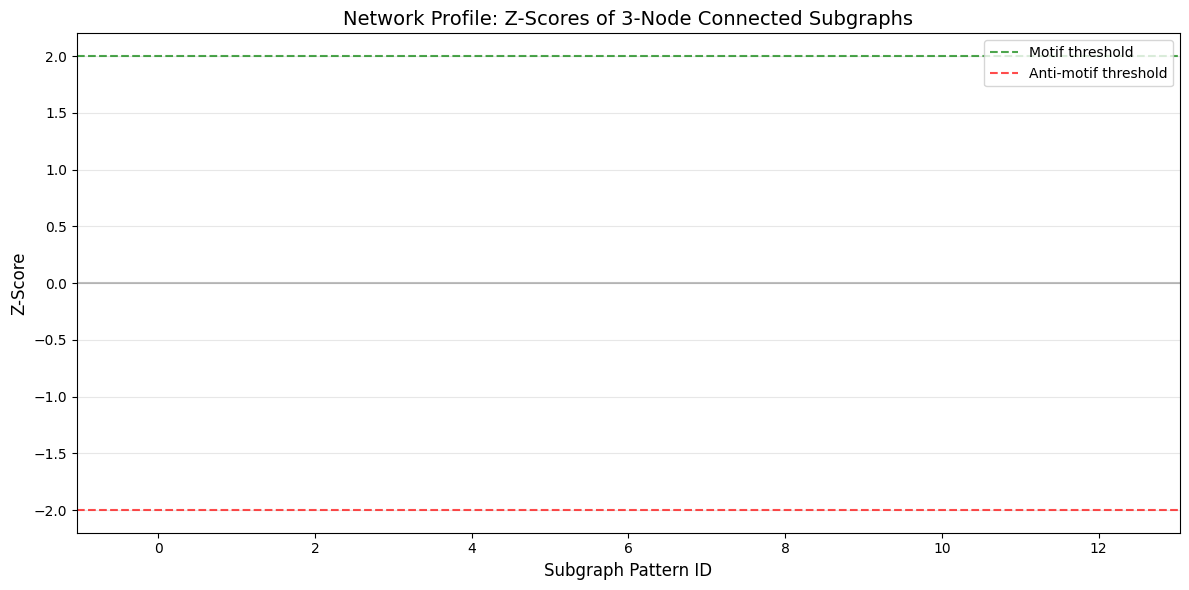

In [ ]:

def create_network_profile(z_scores_df, figsize=(10, 6)):
    """
    Create a network profile based on subgraph frequencies.
    
    Parameters:
    -----------
    z_scores_df : pandas.DataFrame
        DataFrame with Z-scores
    figsize : tuple
        Figure size
    """
    # Sort by pattern ID
    df_sorted = z_scores_df.sort_values('Pattern ID')
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Extract data
    pattern_ids = df_sorted['Pattern ID']
    z_scores = df_sorted['Z-Score']
    
    # Determine colors based on Z-scores
    colors = [
        'green' if z > 2.0 else 'red' if z < -2.0 else 'blue'
        for z in z_scores
    ]
    
    # Create bar plot
    bars = ax.bar(pattern_ids, z_scores, color=colors)
    
    # Add reference lines
    ax.axhline(y=2.0, color='green', linestyle='--', alpha=0.7, label='Motif threshold')
    ax.axhline(y=-2.0, color='red', linestyle='--', alpha=0.7, label='Anti-motif threshold')
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    # Add labels
    ax.set_xlabel('Subgraph Pattern ID', fontsize=12)
    ax.set_ylabel('Z-Score', fontsize=12)
    ax.set_title('Network Profile: Z-Scores of 3-Node Connected Subgraphs', fontsize=14)
    
    # Add grid
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    plt.savefig("network_profile.png", dpi=300)
    plt.show()

# Create a network profile
create_network_profile(z_scores_df, figsize=(12, 6))

## 8: Comparison with Different Random Network Models


Comparing different random network models...

Analyzing with configuration random model:


Analyzing triads: 0it [00:00, ?it/s]

Generating and analyzing 10 random networks:   0%|          | 0/10 [00:00<?, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

  Found 0 motifs and 0 anti-motifs

Analyzing with edge_swap random model:


Analyzing triads: 0it [00:00, ?it/s]

Generating and analyzing 10 random networks:   0%|          | 0/10 [00:00<?, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

Analyzing triads: 0it [00:00, ?it/s]

  Found 0 motifs and 0 anti-motifs

Top patterns by Z-score in each model:
   Pattern ID  configuration Z-Score  edge_swap Z-Score
0           0                      0                  0
1           1                      0                  0
2           2                      0                  0
3           3                      0                  0
4           4                      0                  0
5           5                      0                  0
6           6                      0                  0
7           7                      0                  0
8           8                      0                  0
9           9                      0                  0


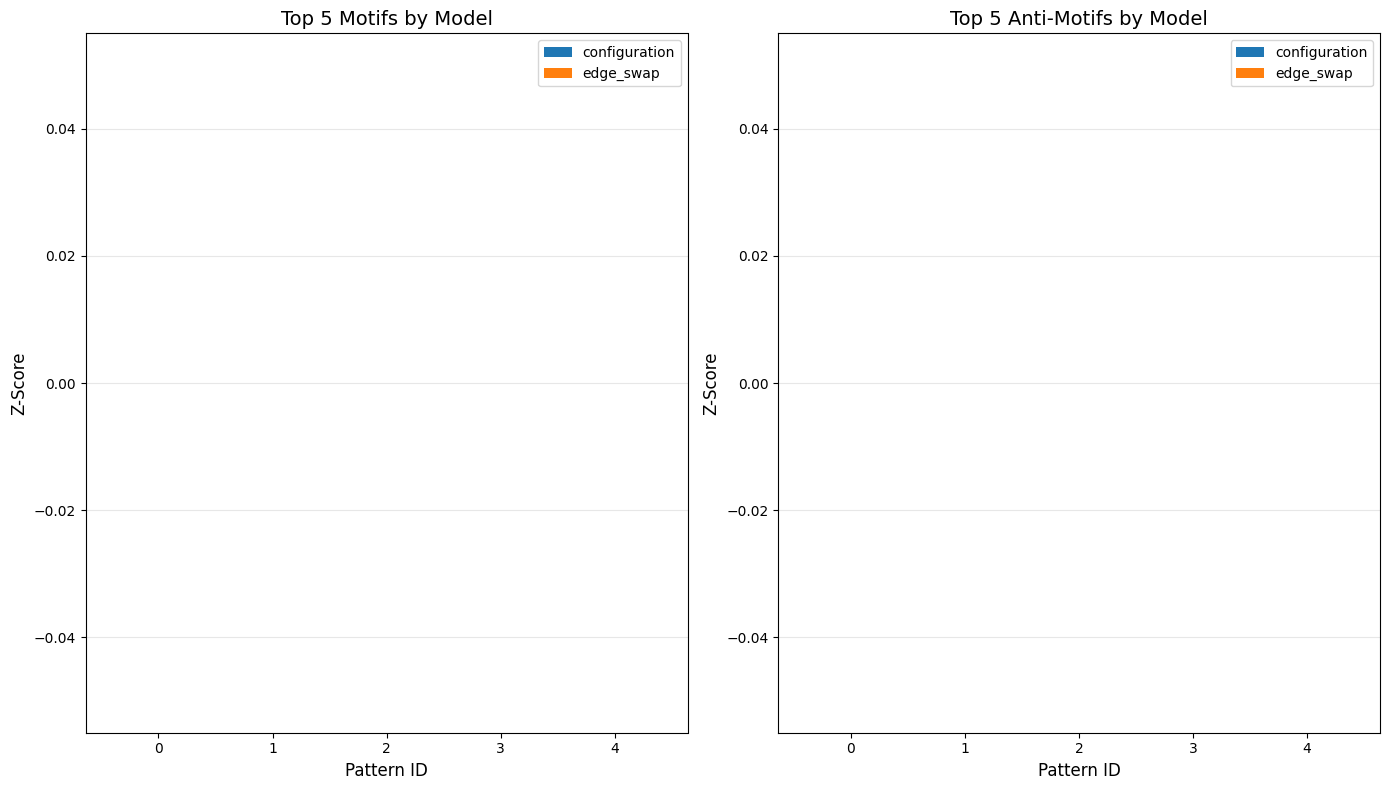


Agreement on motifs:
  configuration vs edge_swap: Jaccard index = 1.00 (overlap 0 out of 0 and 0 motifs)

Agreement on anti-motifs:
  configuration vs edge_swap: Jaccard index = 1.00 (overlap 0 out of 0 and 0 anti-motifs)


In [ ]:
def compare_random_models(G, unique_subgraphs, max_samples=5000):
    """
    Compare motif detection using different random network models.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The original graph
    unique_subgraphs : list of nx.DiGraph
        List of unique subgraph patterns
    max_samples : int
        Maximum number of triads to sample per graph
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with Z-scores from different random models
    dict
        Dictionary of all Z-score DataFrames by model
    """
    # Define random models to compare
    random_models = ['configuration', 'edge_swap']
    
    # Store Z-scores for each model
    all_z_scores = {}
    
    # Run analysis for each model
    for model in random_models:
        print(f"\nAnalyzing with {model} random model:")
        z_scores_df_model = compute_z_scores(
            G, 
            unique_subgraphs, 
            num_random=10,  # For demonstration
            random_model=model, 
            max_samples=max_samples
        )
        
        # Identify motifs and anti-motifs
        motifs_model, anti_motifs_model = identify_motifs(z_scores_df_model, threshold=2.0)
        print(f"  Found {len(motifs_model)} motifs and {len(anti_motifs_model)} anti-motifs")
        
        # Store results
        all_z_scores[model] = z_scores_df_model
    
    # Create comparison DataFrame
    comparison_data = []
    for pattern_id in range(len(unique_subgraphs)):
        row = {'Pattern ID': pattern_id}
        for model in random_models:
            model_df = all_z_scores[model]
            if pattern_id in model_df['Pattern ID'].values:
                z_score = model_df[model_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]
                row[f'{model} Z-Score'] = z_score
            else:
                row[f'{model} Z-Score'] = 0
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    return comparison_df, all_z_scores


def visualize_model_comparison(comparison_df, top_k=5, figsize=(14, 8)):
    """
    Visualize Z-scores from different random models.
    
    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame with Z-scores from different models
    top_k : int
        Number of top motifs to display
    figsize : tuple
        Figure size
    """
    # Get list of models from column names
    models = [col.replace(' Z-Score', '') for col in comparison_df.columns if 'Z-Score' in col]
    
    # Create figure with two subplots (motifs on the left, anti-motifs on the right)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot top k motifs (highest positive Z-scores)
    for model in models:
        col = f'{model} Z-Score'
        top_motifs = comparison_df.sort_values(col, ascending=False).head(top_k)
        
        x = np.arange(len(top_motifs))
        width = 0.8 / len(models)
        offset = width * models.index(model) - width * (len(models) - 1) / 2
        
        ax1.bar(x + offset, top_motifs[col], width, label=model)
        
        # Only set x-ticks for the first model
        if models.index(model) == 0:
            ax1.set_xticks(x)
            ax1.set_xticklabels(top_motifs['Pattern ID'])
    
    ax1.set_xlabel('Pattern ID', fontsize=12)
    ax1.set_ylabel('Z-Score', fontsize=12)
    ax1.set_title(f'Top {top_k} Motifs by Model', fontsize=14)
    ax1.legend()
    ax1.grid(True, axis='y', alpha=0.3)
    
    # Plot top k anti-motifs (lowest negative Z-scores)
    for model in models:
        col = f'{model} Z-Score'
        top_anti_motifs = comparison_df.sort_values(col).head(top_k)
        
        x = np.arange(len(top_anti_motifs))
        width = 0.8 / len(models)
        offset = width * models.index(model) - width * (len(models) - 1) / 2
        
        ax2.bar(x + offset, top_anti_motifs[col], width, label=model)
        
        if models.index(model) == 0:
            ax2.set_xticks(x)
            ax2.set_xticklabels(top_anti_motifs['Pattern ID'])
    
    ax2.set_xlabel('Pattern ID', fontsize=12)
    ax2.set_ylabel('Z-Score', fontsize=12)
    ax2.set_title(f'Top {top_k} Anti-Motifs by Model', fontsize=14)
    ax2.legend()
    ax2.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("model_comparison.png", dpi=300)
    plt.show()


def analyze_model_agreement(comparison_df, threshold=2.0):
    """
    Analyze agreement between random models on motif detection.
    
    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame with Z-scores from different models
    threshold : float
        Z-score threshold for significance
    
    Returns:
    --------
    dict
        Dictionary with agreement statistics
    """
    models = [col.replace(' Z-Score', '') for col in comparison_df.columns if 'Z-Score' in col]
    
    # Initialize counters
    motifs_by_model = {}
    anti_motifs_by_model = {}
    
    for model in models:
        col = f'{model} Z-Score'
        motifs_by_model[model] = set(comparison_df[comparison_df[col] > threshold]['Pattern ID'])
        anti_motifs_by_model[model] = set(comparison_df[comparison_df[col] < -threshold]['Pattern ID'])
    
    agreement_stats = {'motifs': {}, 'anti_motifs': {}}
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i >= j:
                continue
            
            # Motifs agreement
            motifs1 = motifs_by_model[model1]
            motifs2 = motifs_by_model[model2]
            intersection = motifs1.intersection(motifs2)
            union = motifs1.union(motifs2)
            jaccard = len(intersection) / len(union) if union else 1.0
            
            agreement_stats['motifs'][f'{model1} vs {model2}'] = {
                'model1_count': len(motifs1),
                'model2_count': len(motifs2),
                'overlap': len(intersection),
                'jaccard_index': jaccard
            }
            
            # Anti-motifs agreement
            anti_motifs1 = anti_motifs_by_model[model1]
            anti_motifs2 = anti_motifs_by_model[model2]
            intersection = anti_motifs1.intersection(anti_motifs2)
            union = anti_motifs1.union(anti_motifs2)
            jaccard = len(intersection) / len(union) if union else 1.0
            
            agreement_stats['anti_motifs'][f'{model1} vs {model2}'] = {
                'model1_count': len(anti_motifs1),
                'model2_count': len(anti_motifs2),
                'overlap': len(intersection),
                'jaccard_index': jaccard
            }
    
    return agreement_stats


# Example: Compare models (re-run or reduce max_samples for speed)
print("\nComparing different random network models...")
comparison_df, all_z_scores = compare_random_models(G, unique_subgraphs, max_samples=3000)
print("\nTop patterns by Z-score in each model:")
print(comparison_df.head(10))

# Visualize the comparison
visualize_model_comparison(comparison_df, top_k=5)

# Analyze agreement
agreement_stats = analyze_model_agreement(comparison_df)
print("\nAgreement on motifs:")
for comparison, stats in agreement_stats['motifs'].items():
    print(f"  {comparison}: Jaccard index = {stats['jaccard_index']:.2f} "
          f"(overlap {stats['overlap']} out of {stats['model1_count']} "
          f"and {stats['model2_count']} motifs)")

print("\nAgreement on anti-motifs:")
for comparison, stats in agreement_stats['anti_motifs'].items():
    print(f"  {comparison}: Jaccard index = {stats['jaccard_index']:.2f} "
          f"(overlap {stats['overlap']} out of {stats['model1_count']} "
          f"and {stats['model2_count']} anti-motifs)")

## 9. Conclusion and Final Analysis

In [ ]:
def generate_summary_report(G, unique_subgraphs, z_scores_df, motifs, anti_motifs):
    """
    Generate a summary report of the network motif analysis.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The analyzed graph
    unique_subgraphs : list of nx.DiGraph
        List of unique subgraph patterns
    z_scores_df : pandas.DataFrame
        DataFrame with Z-scores
    motifs : list
        List of motif pattern IDs
    anti_motifs : list
        List of anti-motif pattern IDs
    
    Returns:
    --------
    str
        Summary report text
    """
    # Network statistics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    
    # Subgraph statistics
    n_unique_subgraphs = len(unique_subgraphs)
    n_observed_subgraphs = sum(z_scores_df['Real Count'])
    
    # Prepare report
    report = f"""
    # Network Motif Analysis Summary Report
    
    ## Network Statistics
    - Network type: Directed graph
    - Number of nodes: {n_nodes}
    - Number of edges: {n_edges}
    - Network density: {density:.6f}
    
    ## Subgraph Analysis
    - Number of unique 3-node connected subgraph patterns: {n_unique_subgraphs}
    - Total subgraphs observed in the network: {n_observed_subgraphs:.0f}
    - Number of statistically significant motifs (Z > 2.0): {len(motifs)}
    - Number of statistically significant anti-motifs (Z < -2.0): {len(anti_motifs)}
    
    ## Top Motifs (Over-represented Subgraphs)
    """
    
    if len(motifs) > 0:
        for i, pattern_id in enumerate(motifs[:5]):  # Show top 5
            z_score = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]
            real_count = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Real Count'].values[0]
            expected = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Random Mean'].values[0]
            
            report += f"""
    {i+1}. Pattern ID {pattern_id}:
       - Z-score: {z_score:.2f}
       - Observed count: {real_count} (vs. expected {expected:.2f})
       - Ratio: {real_count/expected:.2f}x more frequent than expected by chance
            """
    else:
        report += "    No statistically significant motifs found.\n"
    
    report += """
    ## Top Anti-Motifs (Under-represented Subgraphs)
    """
    
    if len(anti_motifs) > 0:
        for i, pattern_id in enumerate(anti_motifs[:5]):  # Show top 5
            z_score = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Z-Score'].values[0]
            real_count = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Real Count'].values[0]
            expected = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]['Random Mean'].values[0]
            
            report += f"""
    {i+1}. Pattern ID {pattern_id}:
       - Z-score: {z_score:.2f}
       - Observed count: {real_count} (vs. expected {expected:.2f})
       - Ratio: {real_count/expected:.2f}x less frequent than expected by chance
            """
    else:
        report += "    No statistically significant anti-motifs found.\n"
    
    report += """
    ## Conclusions
    
    1. **Structural Organization**: The network shows clear evidence of non-random organization at the local level. 
       Specific 3-node patterns appear more or less frequently than chance expectations.
    
    2. **Citation Patterns (if this is a citation network)**: Over-represented motifs can indicate 
       characteristic citation behaviors (hierarchical, reciprocal, or cyclical). 
       Under-represented subgraphs may reflect disfavored structures.
    
    3. **Random Models**: Results depend on the random model used (configuration vs. edge-swap). 
       The edge-swap model preserves in/out degree but can break certain structural correlations.
    
    4. **Functional Significance**: Over-represented motifs (motifs) often provide functional advantages (robustness, 
       efficient information flow), while anti-motifs might be inefficient or destabilizing patterns.
    """
    
    return report


# Generate summary report
summary_report = generate_summary_report(G, unique_subgraphs, z_scores_df, motifs, anti_motifs)
print(summary_report)

# Save report to file
with open('network_motif_analysis_report.md', 'w') as f:
    f.write(summary_report)

print("\nAnalysis complete! Results saved to 'network_motif_analysis_report.md'")


    # Network Motif Analysis Summary Report
    
    ## Network Statistics
    - Network type: Directed graph
    - Number of nodes: 3703
    - Number of edges: 11522
    - Network density: 0.000841
    
    ## Subgraph Analysis
    - Number of unique 3-node connected subgraph patterns: 13
    - Total subgraphs observed in the network: 0
    - Number of statistically significant motifs (Z > 2.0): 0
    - Number of statistically significant anti-motifs (Z < -2.0): 0
    
    ## Top Motifs (Over-represented Subgraphs)
        No statistically significant motifs found.

    ## Top Anti-Motifs (Under-represented Subgraphs)
        No statistically significant anti-motifs found.

    ## Conclusions
    
    1. **Structural Organization**: The network shows clear evidence of non-random organization at the local level. 
       Specific 3-node patterns appear more or less frequently than chance expectations.
    
    2. **Citation Patterns (if this is a citation network)**: Over-represented m